<a href="https://colab.research.google.com/github/IP-04/huggingface_nlp_project_2/blob/main/Task3_Visualizing_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## 0. Dependencies

**Installing Dependencies:**

In [5]:
!pip install transformers --quiet

# 1. Model & Tokenizer Setup

**Load Model & Tokenizer**

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.eval()  # Set to eval mode


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# 2. Picking sentences

**Defining Sample Sentences:**

In [7]:
sentences = [
    "I absolutely love this film, but it’s also very disturbing.",
    "The food was terrible, and I wouldn’t recommend it at all.",
    "I really enjoyed the acting, although the plot was boring.",
    "The movie was not great, but not terrible either.",
    "It’s brilliantly directed but painfully slow."
]


# 3. Retrieve Attention Weights

**Getting Attention Weights:**

In [8]:
def get_attention(sentence):
    # Tokenize and convert to tensors
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass with attention outputs
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attentions and tokens
    attentions = outputs.attentions  # Tuple: (num_layers, batch, num_heads, seq_len, seq_len)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    return attentions, tokens


#  4. Visualize & Analyze

**Visualizing Attention**:

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attn_matrix, tokens, layer, head):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Layer {layer} Head {head}')
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


**Visualizing Attention for One Sentence and One Specific Head:**

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


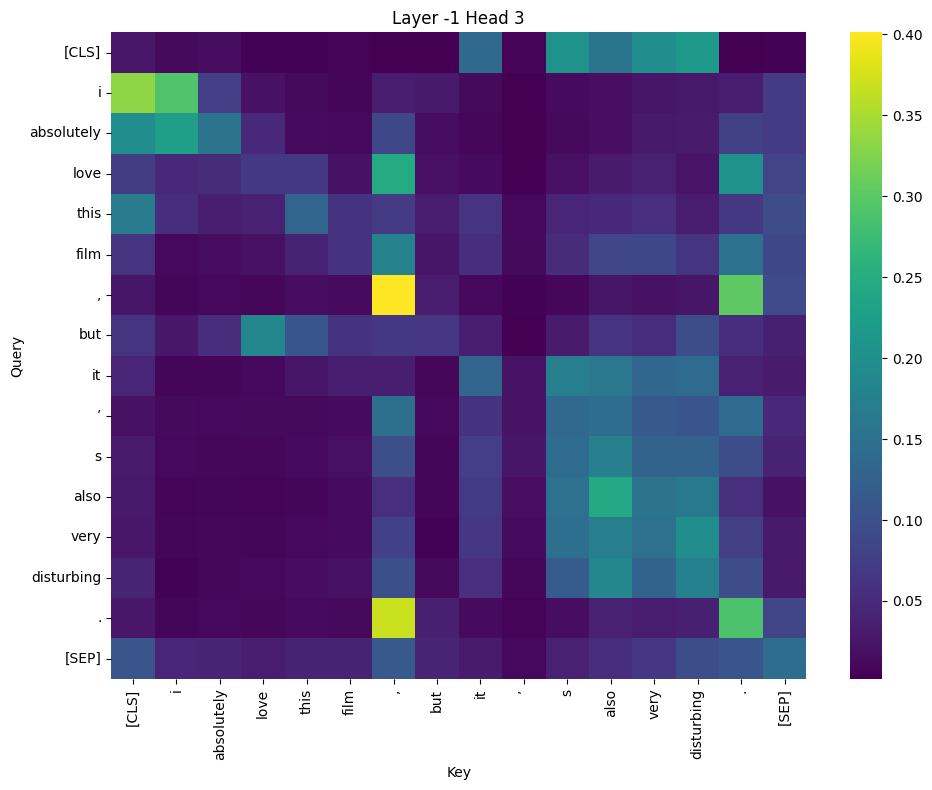

In [10]:
# Example: visualize attention for one sentence
sentence = sentences[0]
attentions, tokens = get_attention(sentence)

# Pick layer 5 (last layer in DistilBERT) and head 3
layer = -1  # last layer
head = 3

# Remove batch dim → [num_heads, seq_len, seq_len]
attn_matrix = attentions[layer][0][head].numpy()

# Plot
plot_attention(attn_matrix, tokens, layer, head)


**Observations from  heatmap of Layer -1 (the final layer) and Head 3**

In this attention head, the model isn’t focusing much on specific words like “love” or “disturbing.” Instead, it's highly tuned into punctuation especially **commas and periods.**

 The strongest self-attention comes from the comma token attending to itself, and to the period. This suggests that Head 3 in the final layer may be specialized in tracking sentence boundaries or clause shifts, rather than detecting sentiment words directly.

  There's a small vertical line of attention to [CLS], meaning several tokens are checking in with the classification token, and a mild cluster of attention near the end of the sentence which could reflect low-level awareness of where the sentence wraps up. But overall, this head is **likely structural, helping the model organize syntax or separate ideas before the final prediction.**

# 5. Variation and changes

**Variation 1: Single-Head vs Multi-Head (Averaged)**

In [13]:
def plot_avg_attention(attentions, tokens, layer):
    avg_attn = attentions[layer][0].mean(dim=0).numpy()  # Mean over heads
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_attn, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Layer {layer} - Averaged Over All Heads')
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


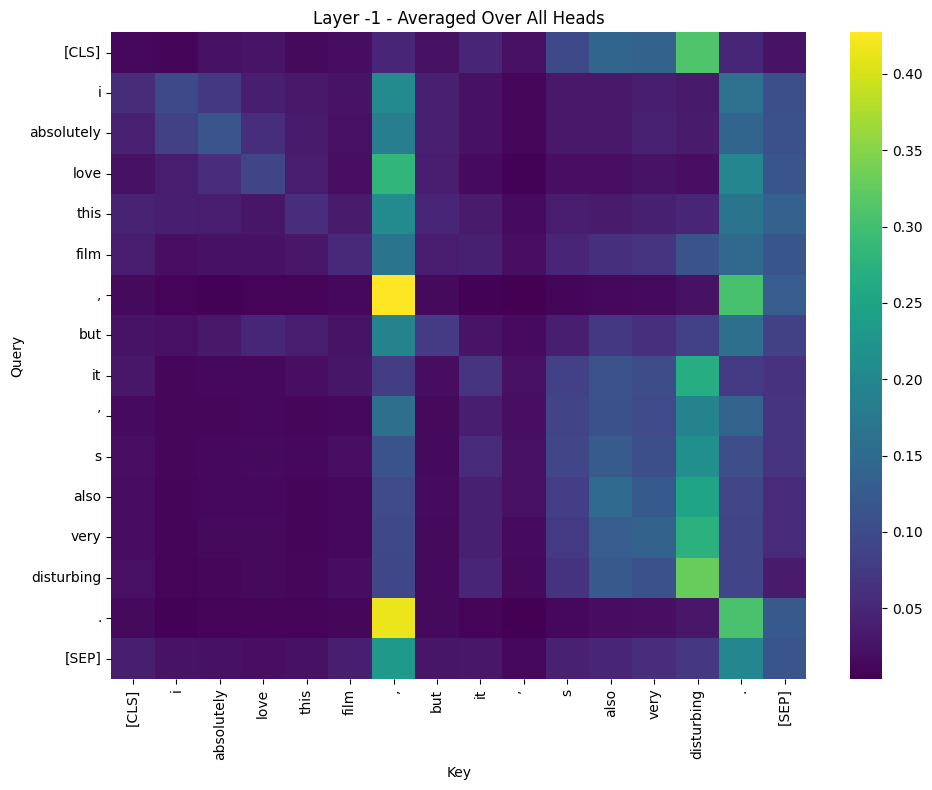

In [14]:
# Compare head average in final layer
plot_avg_attention(attentions, tokens, layer=-1)  # Last layer

**Observation**

This averaged heatmap of the final layer shows a more distributed but still selective attention pattern. The first third of the map is mostly cold (purple), indicating weak attention between early tokens. However, a **vertical column at the comma (",") becomes significantly warmer** especially “.” attending to “,” and “,” attending to itself, with “love” → “,” also getting some attention. This suggests that **punctuation is a consistent focal point across many heads, likely helping the model understand clause boundaries**. Toward the last third of the sentence, attention intensifies again. There’s a growing warm zone around “disturbing”, “.”, and “also”, forming a soft heat cluster in the lower-right corner. This likely reflects multi-head consensus that the sentence ending contains emotionally relevant content. **Interestingly, there’s a faint diagonal line from “I” with “I”, “absolutely” with “absolutely”, etc., suggesting that many heads lightly attend to the token itself** a kind of identity reference, possibly useful for self-reinforcement. Overall, averaging reveals both consistent structural cues (punctuation) and semantic focus (ending sentiment).

**Variation 2: First Layer vs. Last Layer (Both Averaged)**

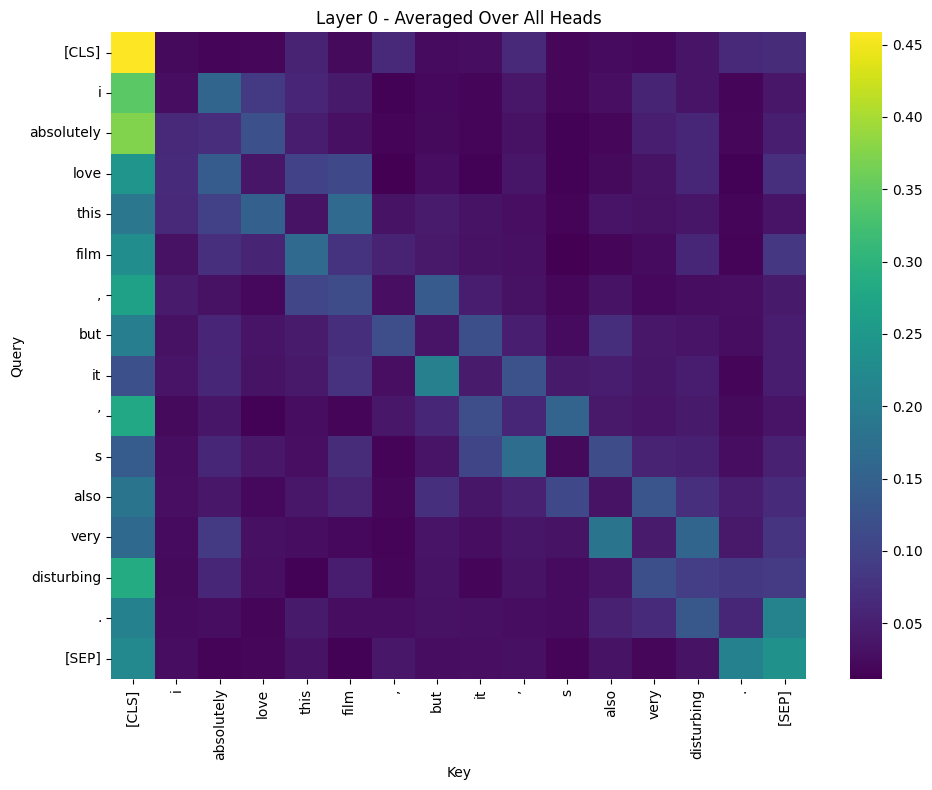

In [16]:
plot_avg_attention(attentions, tokens, layer=0)    # First layer

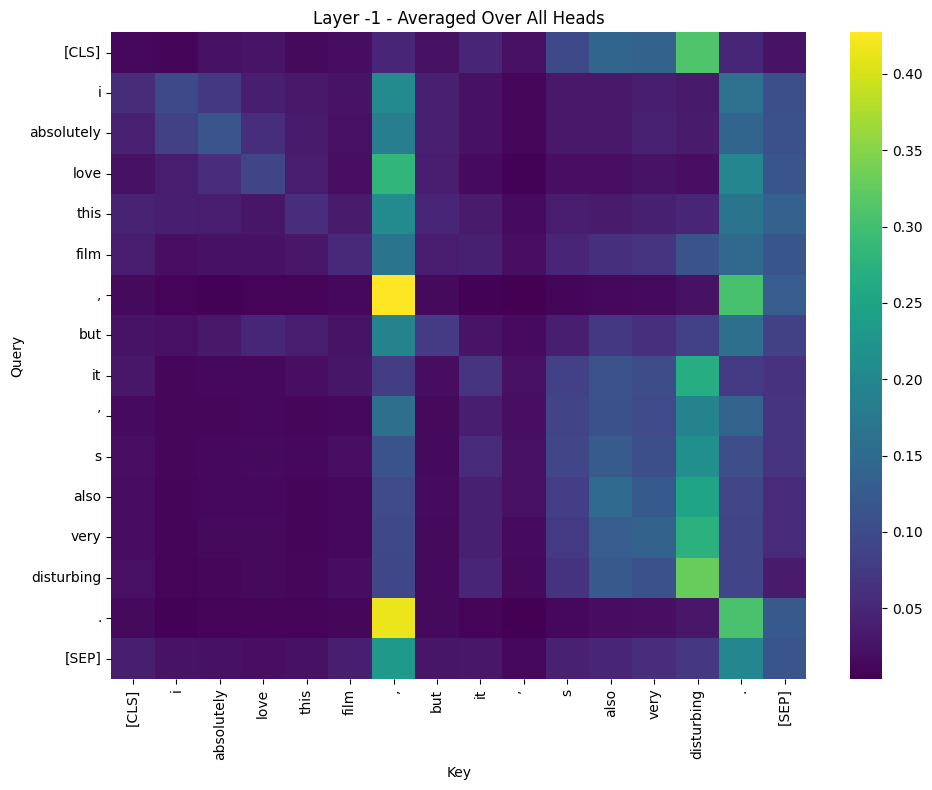

In [17]:
plot_avg_attention(attentions, tokens, layer=-1)   # Last layer

**Observation:**

The attention map for Layer 0, averaged across all heads, presents a **drastically different pattern** compared to the final layer. The [CLS] token column is by far the warmest, with [CLS] attending heavily to itself (top-left yellow block) and moderately to “I” (greenish), while most other tokens pay far less attention to each other.

This heavy focus on [CLS] suggests that early in the network, **multiple heads prioritize encoding information into the classification token** essentially trying to gather initial information for the eventual sentiment prediction.

A second standout feature is **the formation of a pronounced diagonal line ending at the last token,** where tokens lightly attend to themselves. . This diagonal has a layered look, with darker blues inside and lighter blues surrounding it, giving it a sword shape visually reflecting a broad self-attention identity signal, where each token starts to encode its own position and meaning in context.

Outside of this diagonal and the [CLS] column, the map is mostly cold, **indicating that in early layers, deep semantic relationships aren’t formed yet just structure and token-level identity.**

**Variation 3: Head-by-Head Comparison for Two Layers**

In [18]:
def compare_heads(attentions, tokens, layer1, layer2):
    for head in range(attentions[layer1].shape[1]):
        print(f"Layer {layer1}, Head {head}")
        attn1 = attentions[layer1][0][head].numpy()
        plot_attention(attn1, tokens, layer1, head)

    for head in range(attentions[layer2].shape[1]):
        print(f"Layer {layer2}, Head {head}")
        attn2 = attentions[layer2][0][head].numpy()
        plot_attention(attn2, tokens, layer2, head)


Layer 0, Head 0


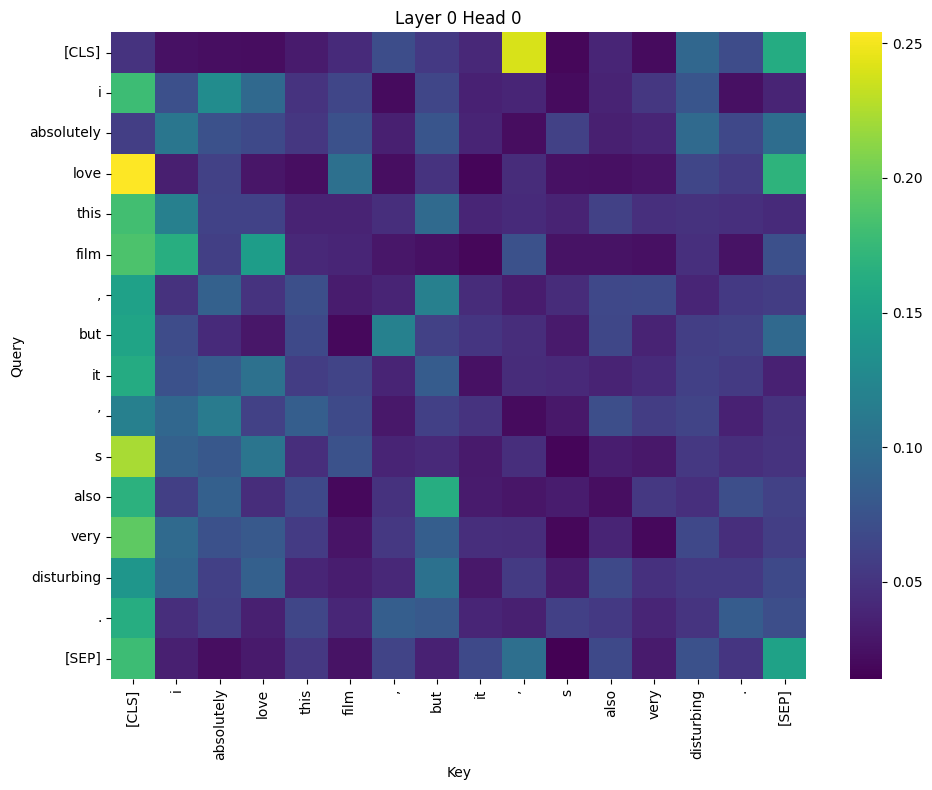

Layer 0, Head 1


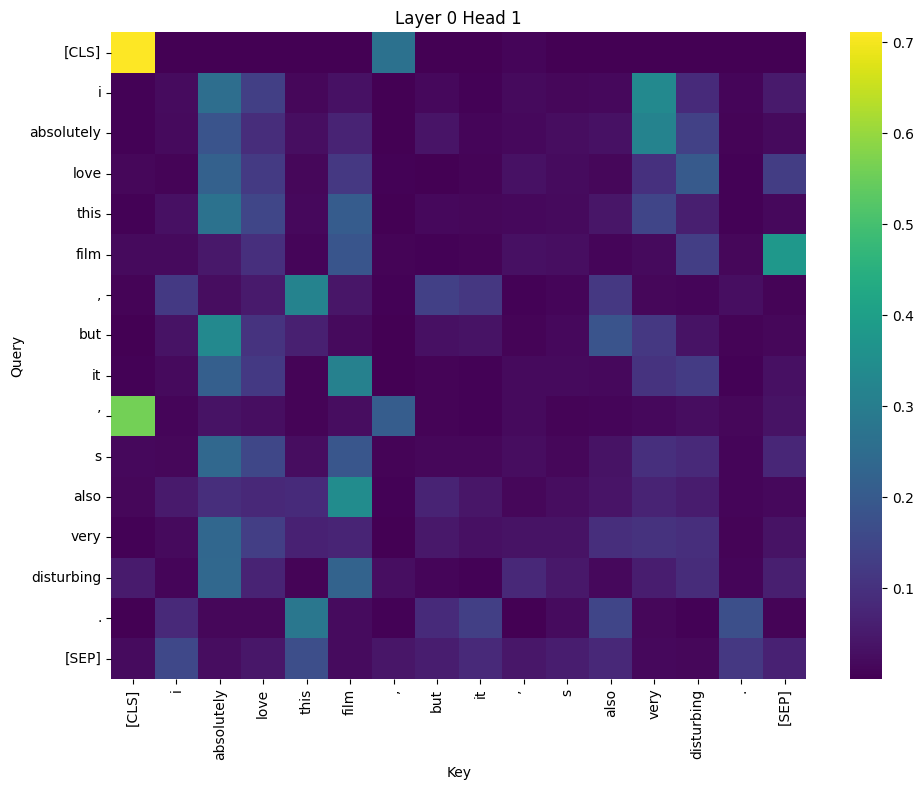

Layer 0, Head 2


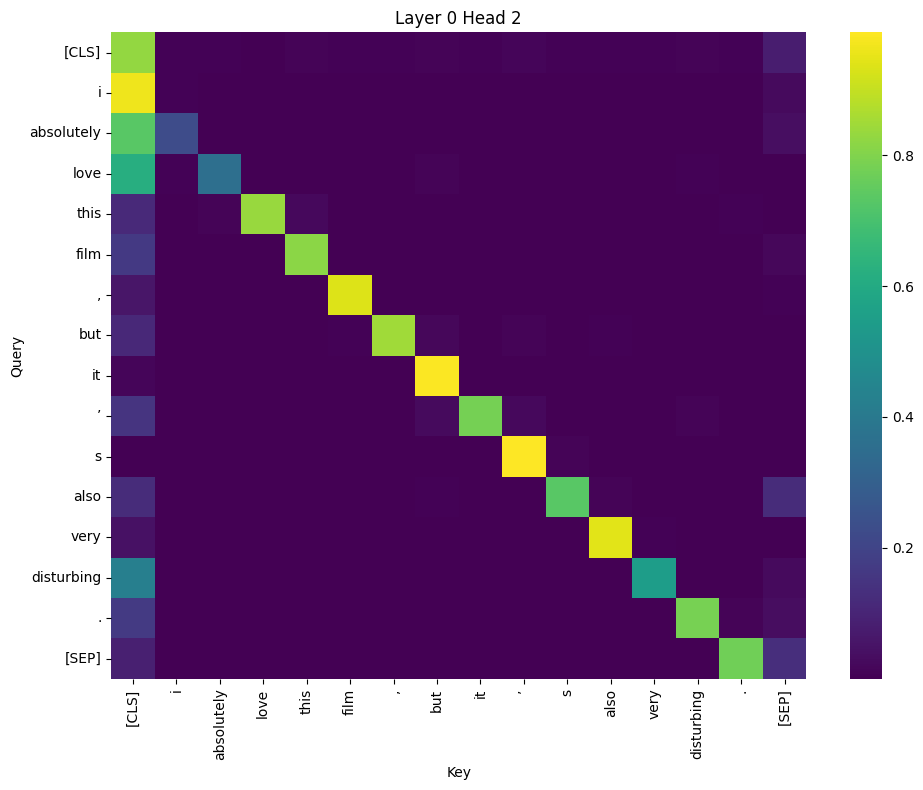

Layer 0, Head 3


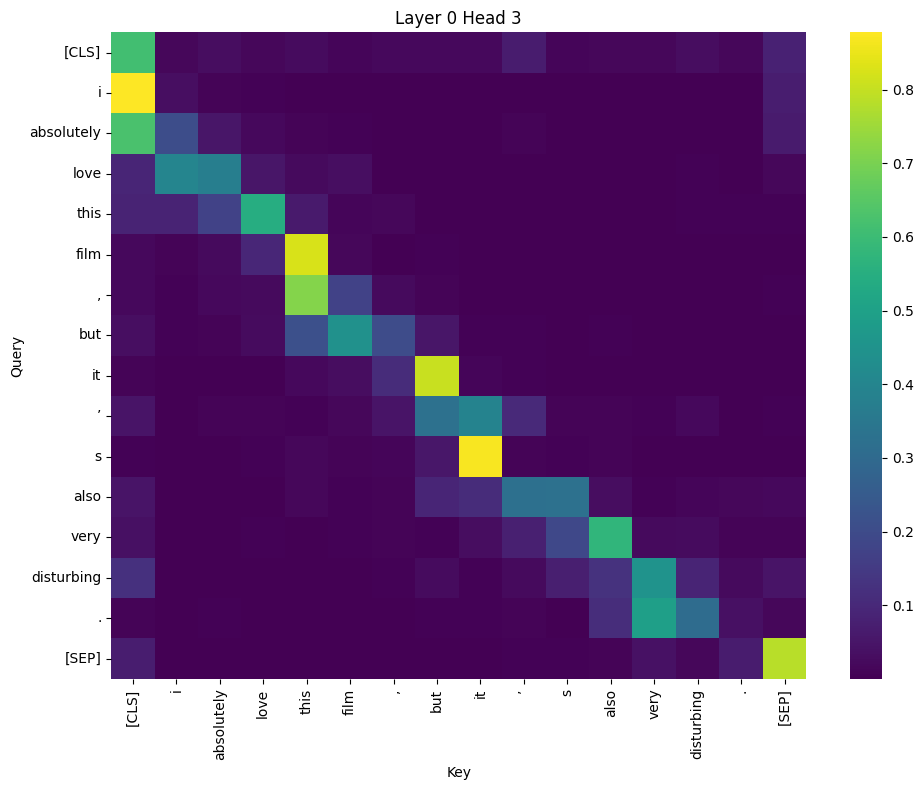

Layer 0, Head 4


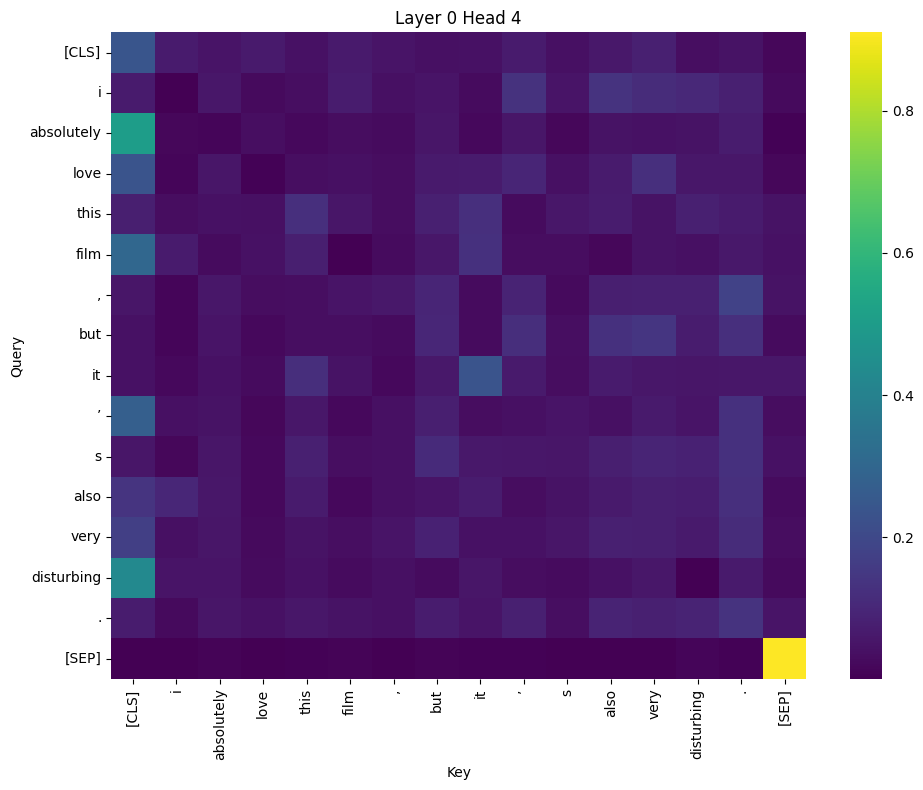

Layer 0, Head 5


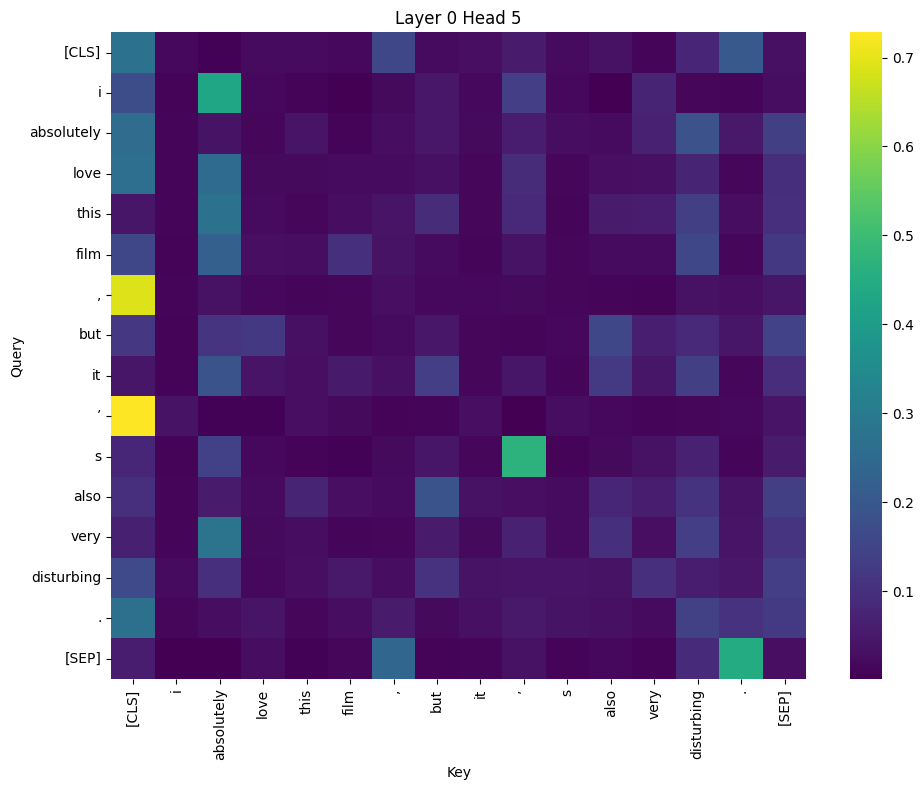

Layer 0, Head 6


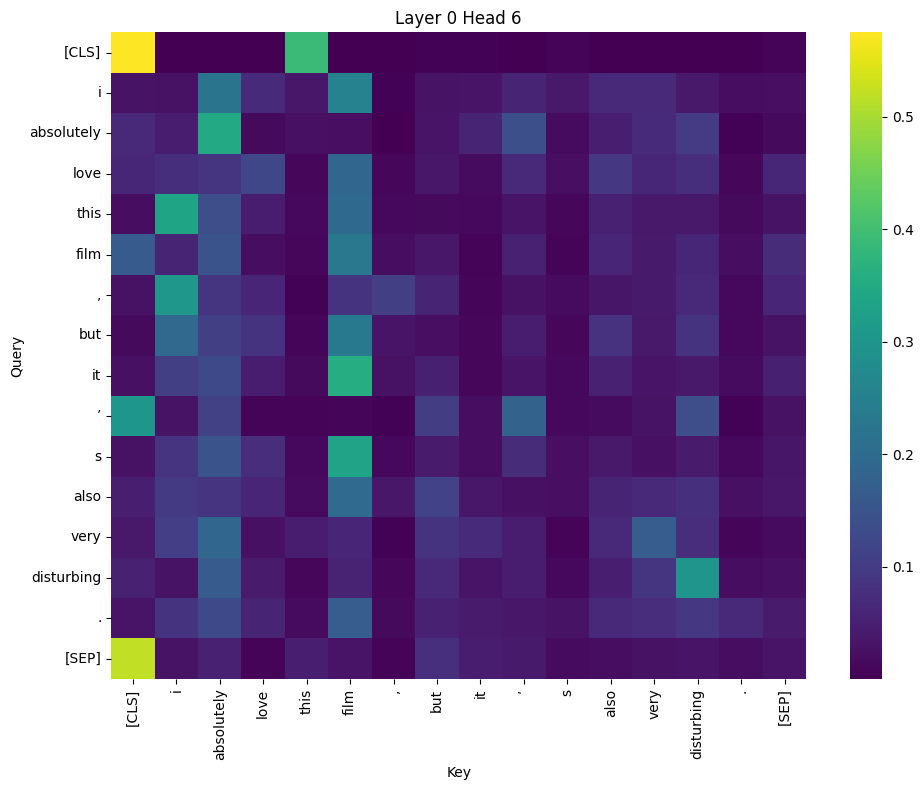

Layer 0, Head 7


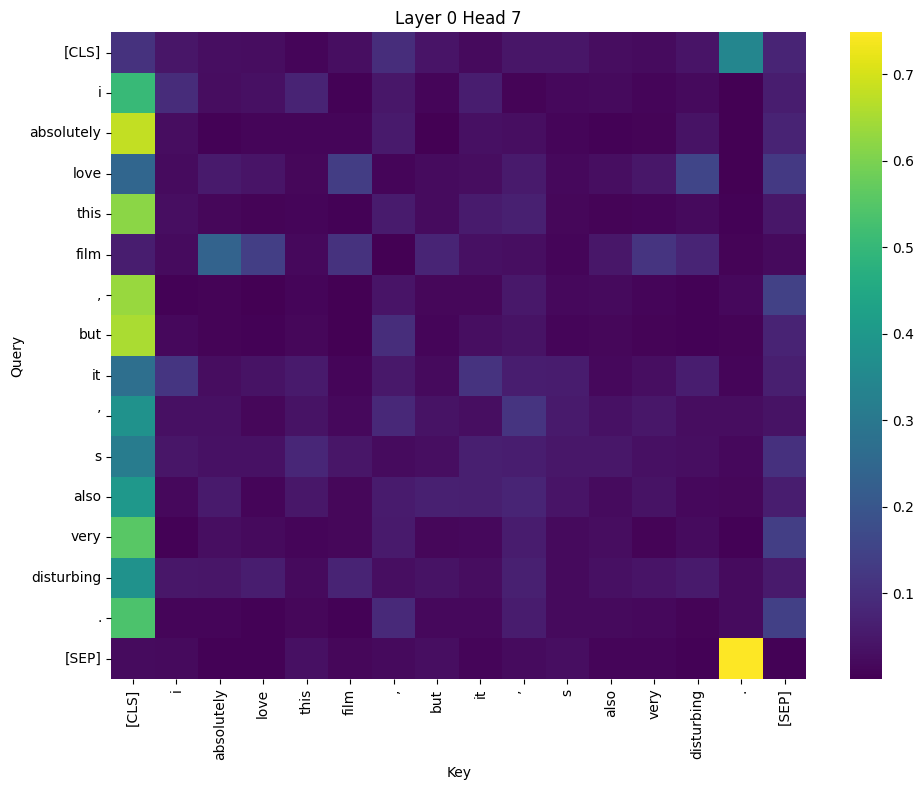

Layer 0, Head 8


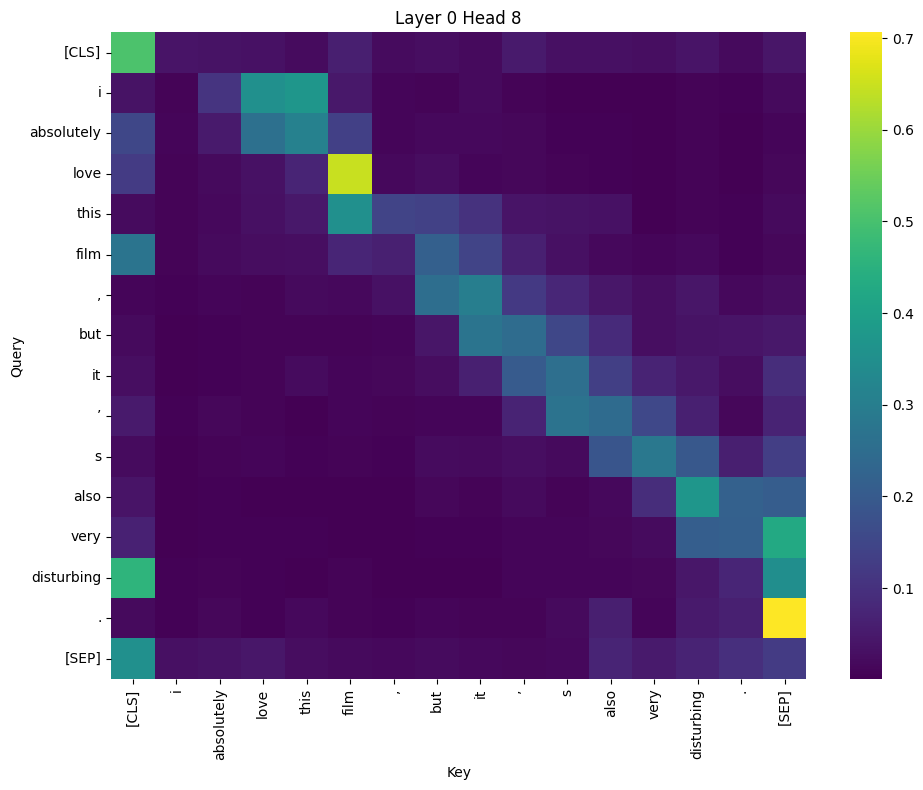

Layer 0, Head 9


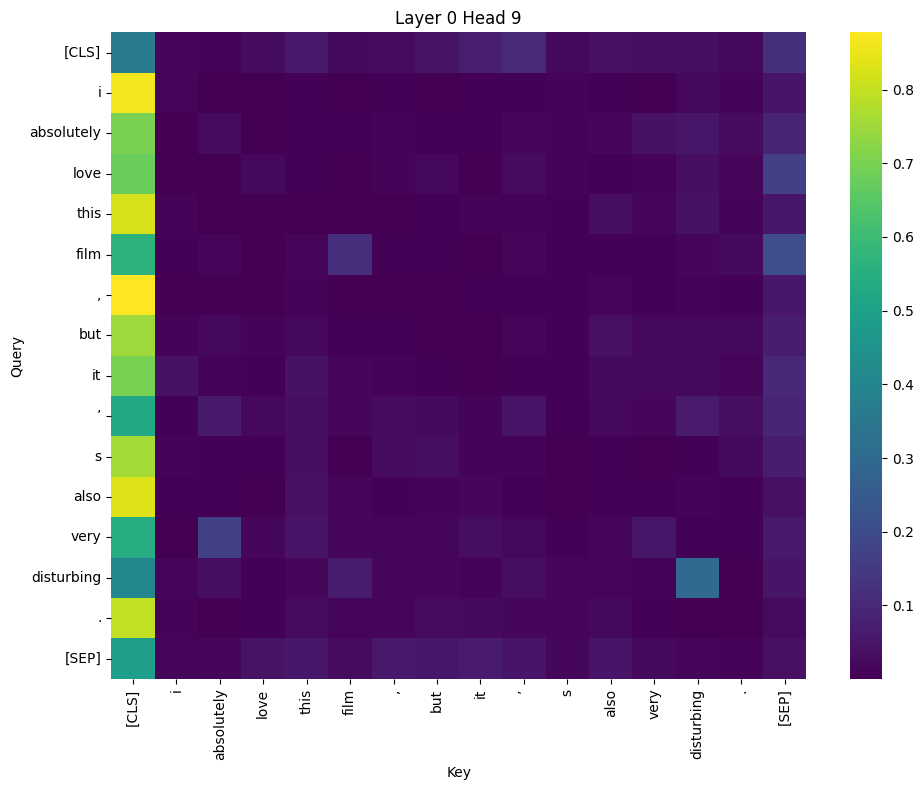

Layer 0, Head 10


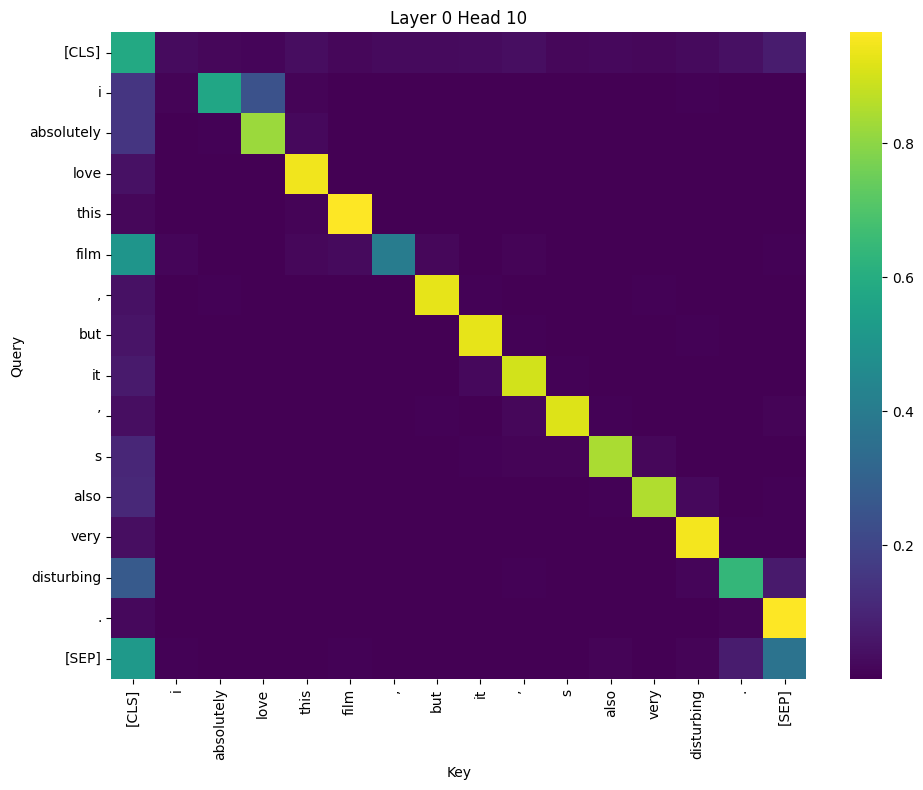

Layer 0, Head 11


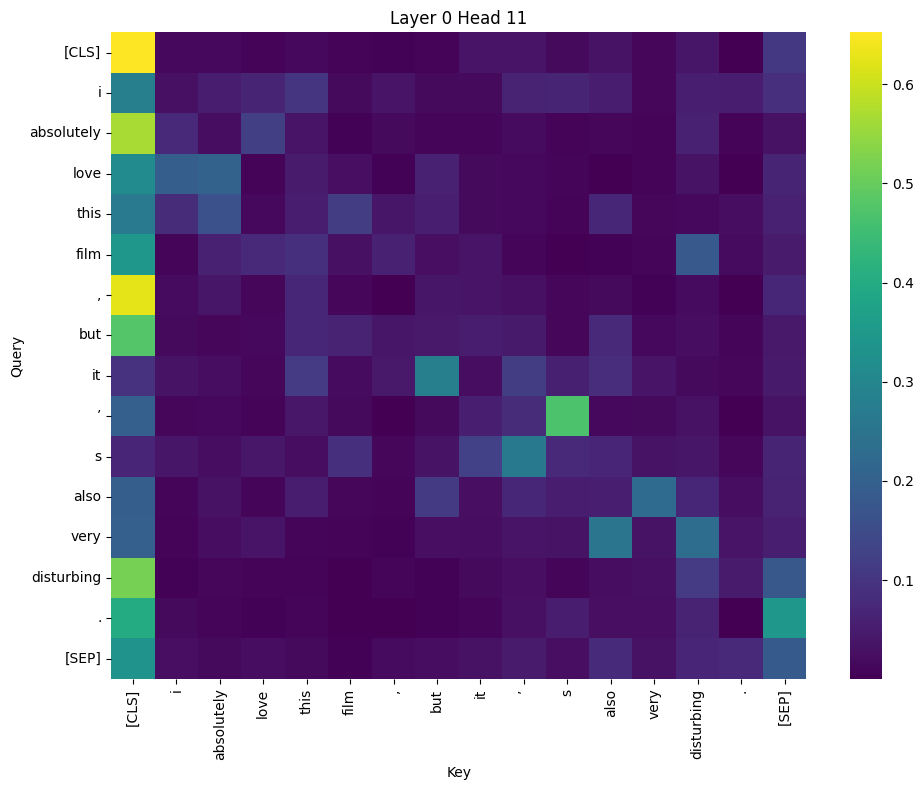

Layer -1, Head 0


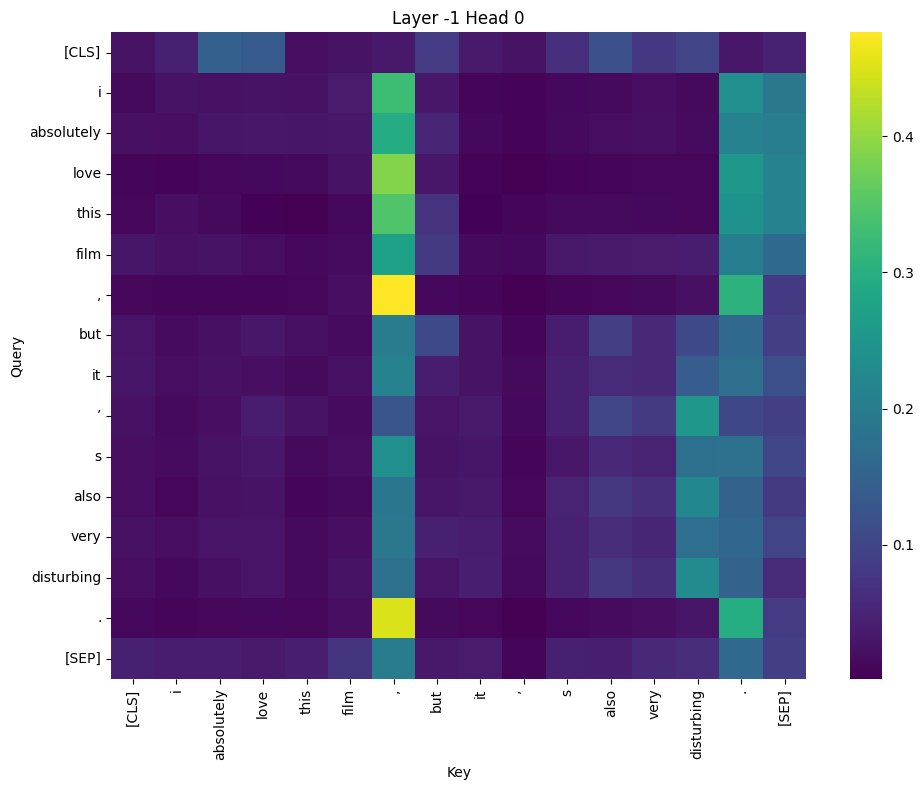

Layer -1, Head 1


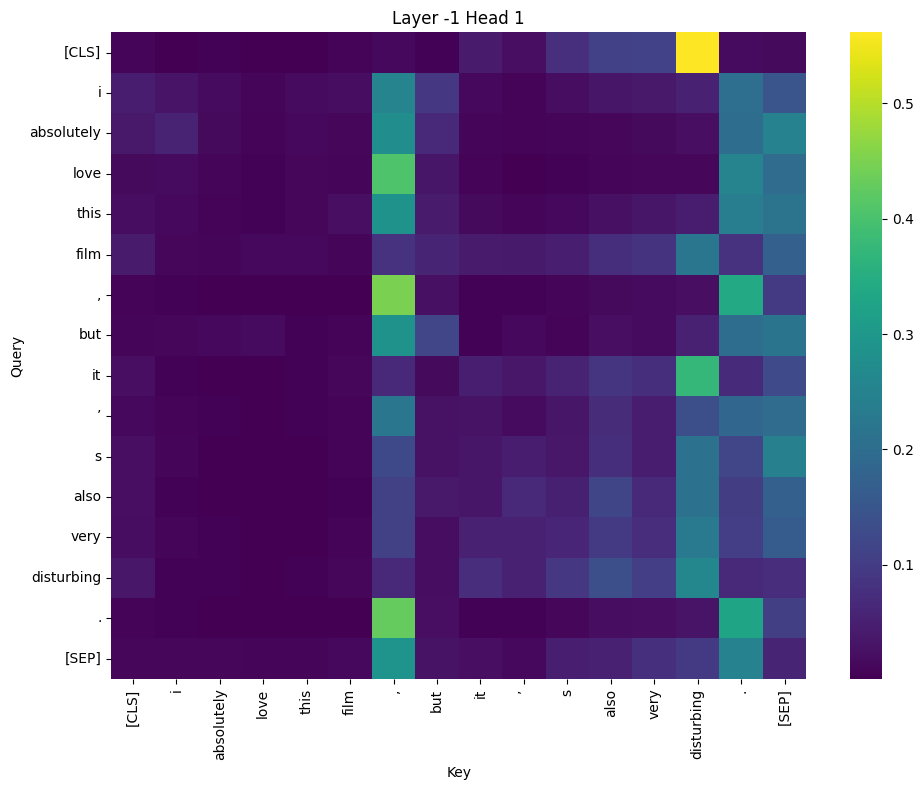

Layer -1, Head 2


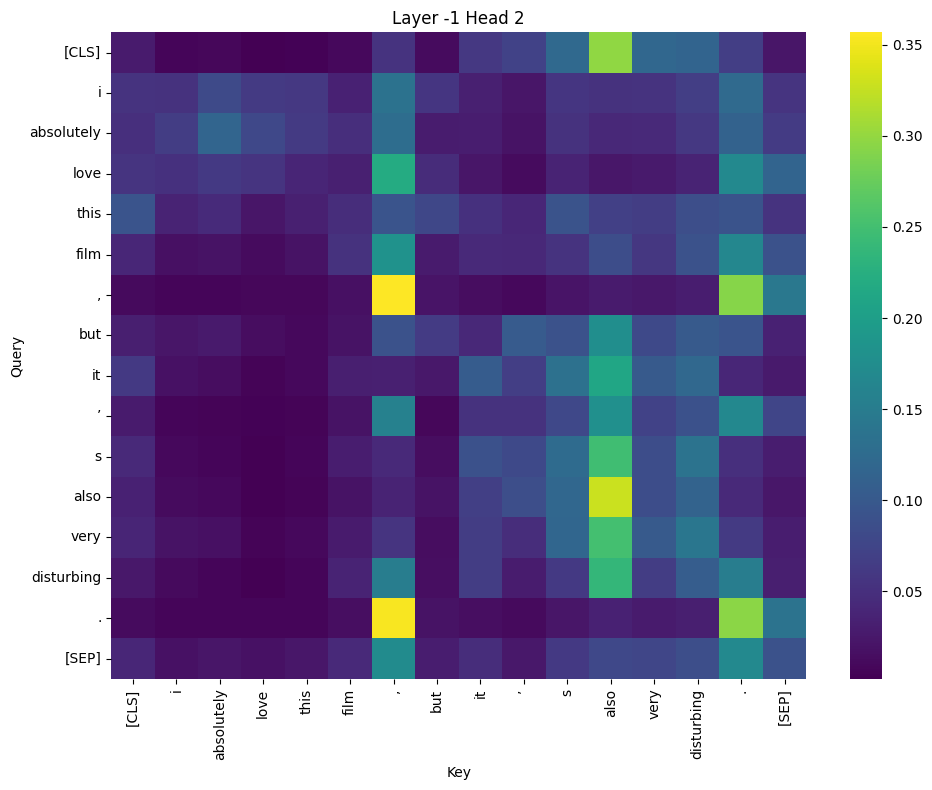

Layer -1, Head 3


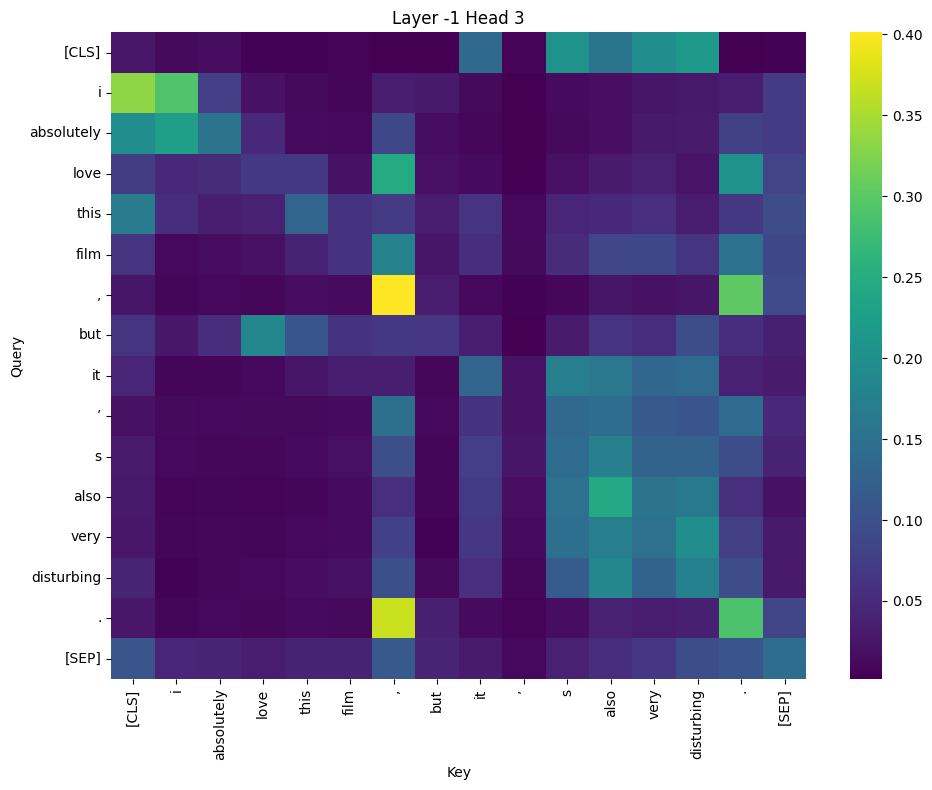

Layer -1, Head 4


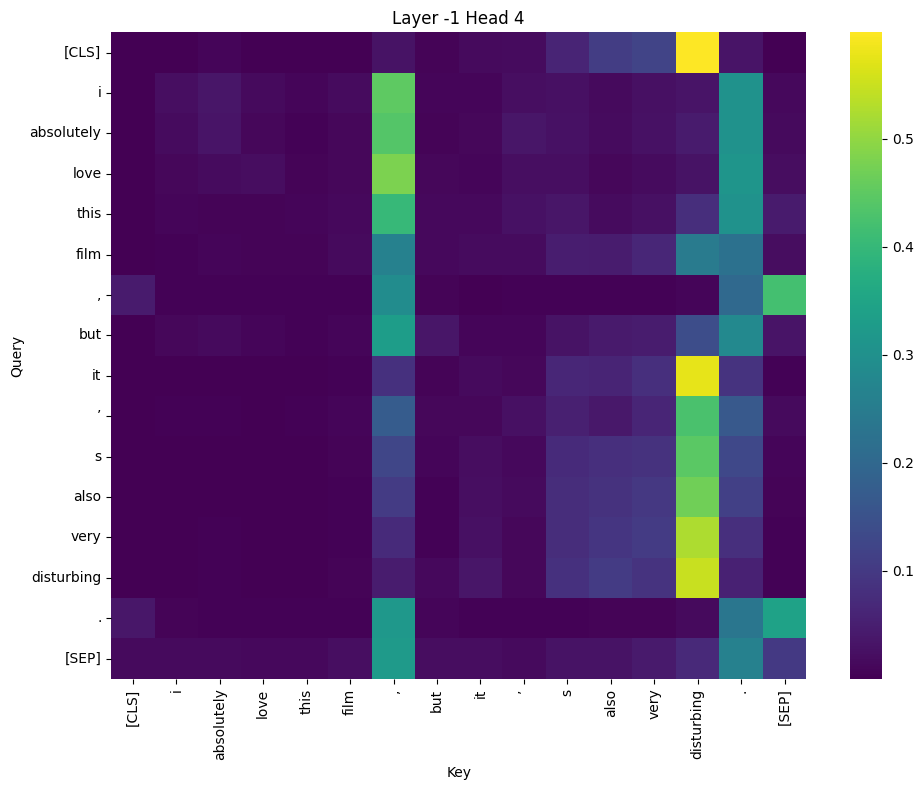

Layer -1, Head 5


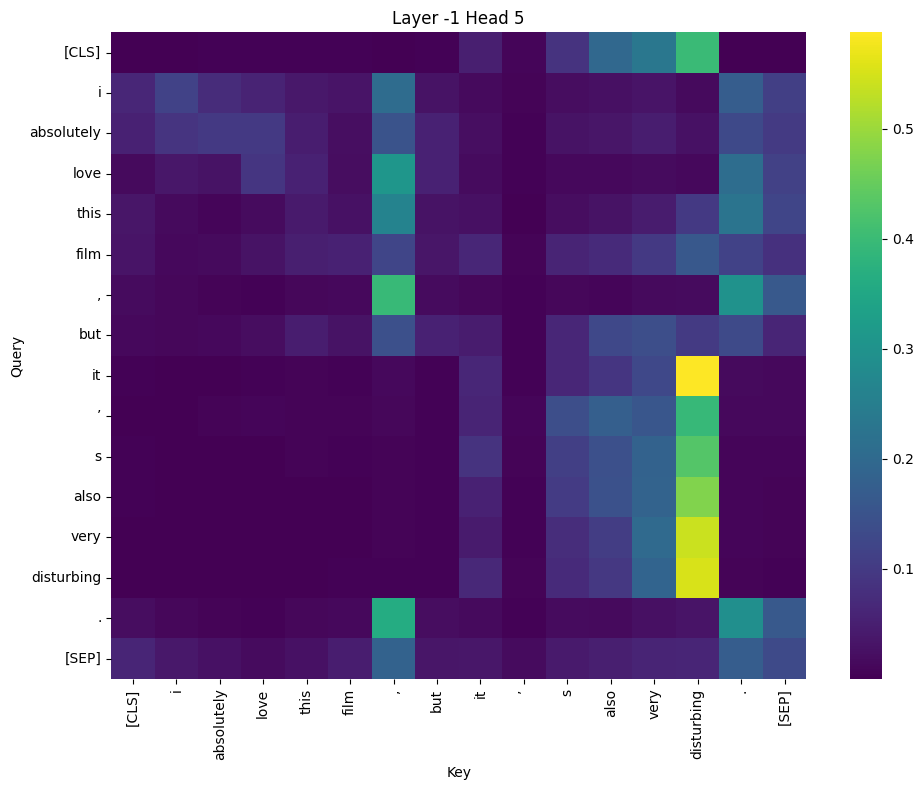

Layer -1, Head 6


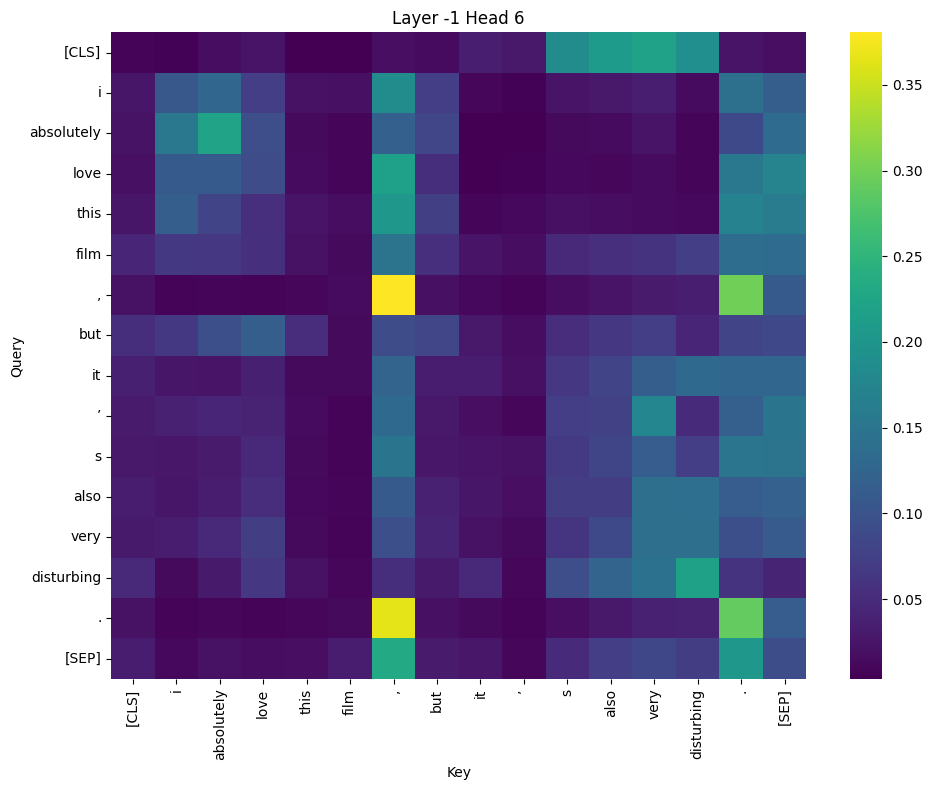

Layer -1, Head 7


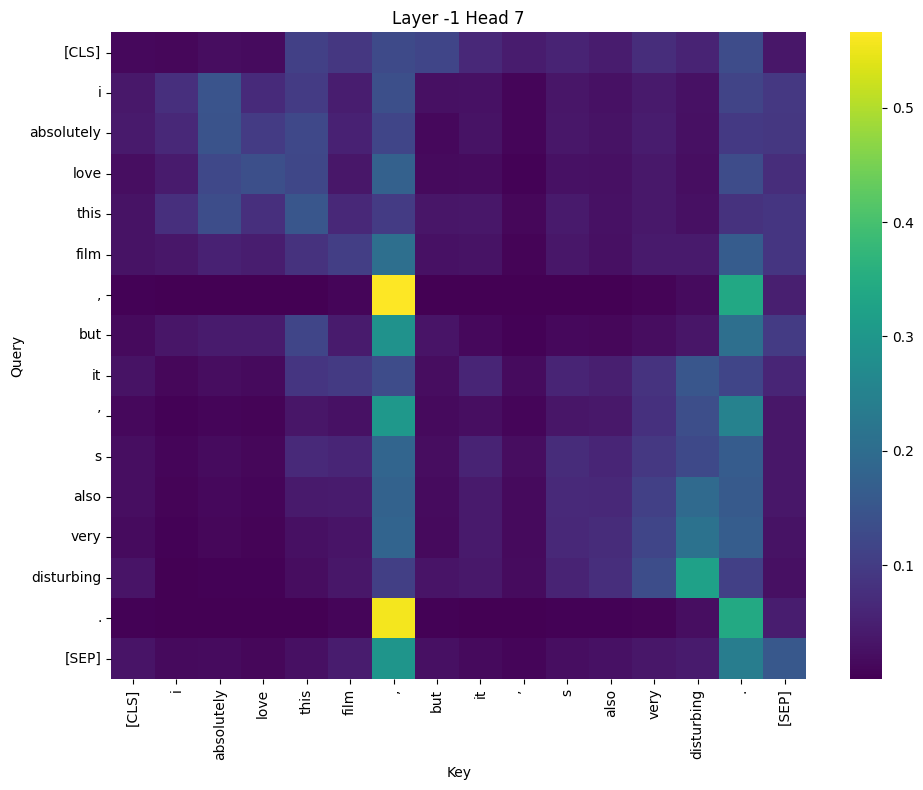

Layer -1, Head 8


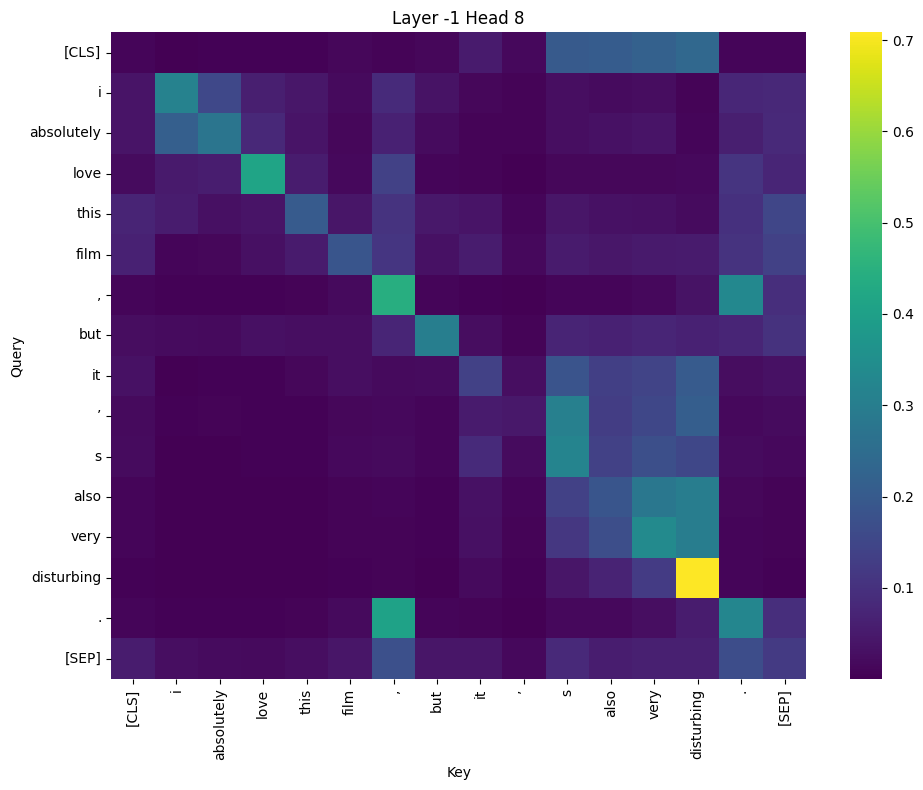

Layer -1, Head 9


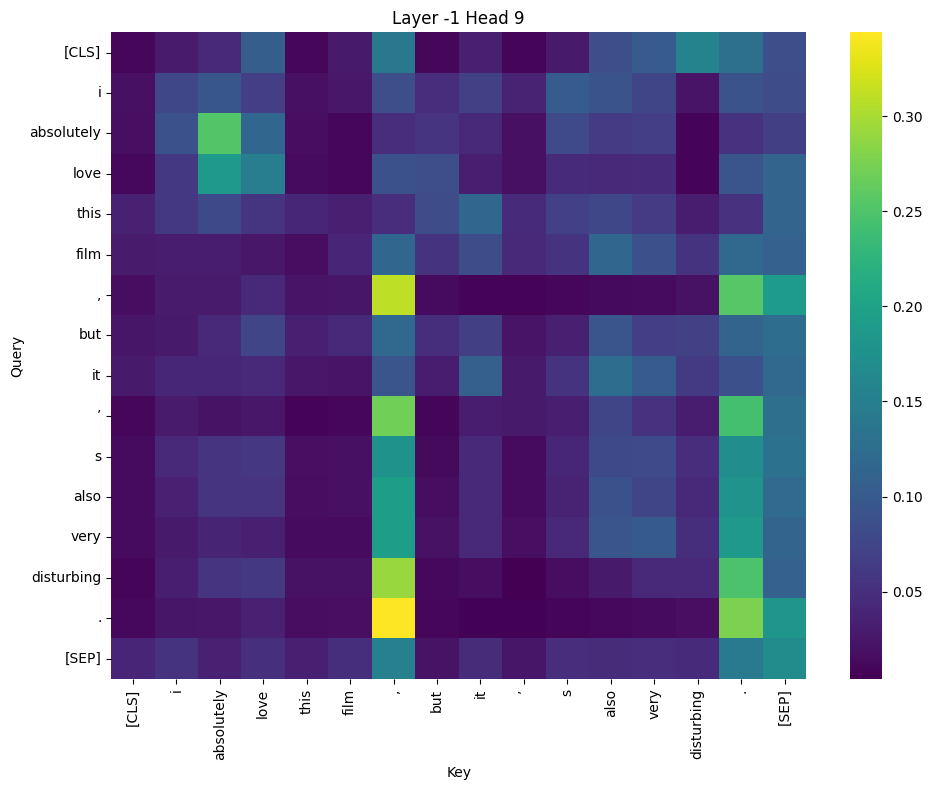

Layer -1, Head 10


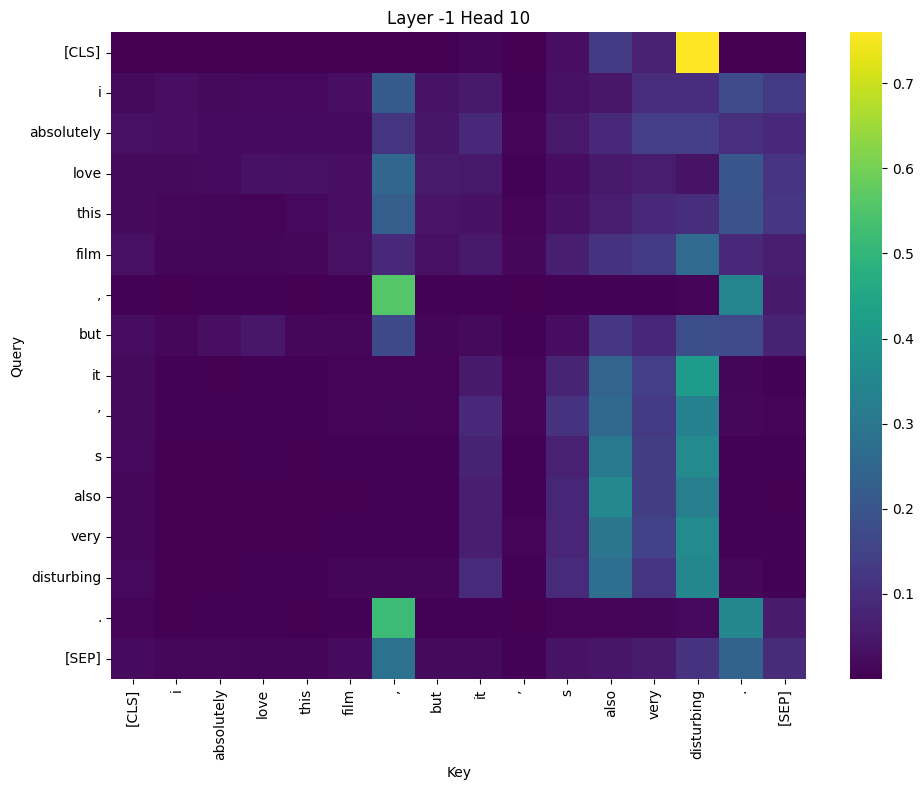

Layer -1, Head 11


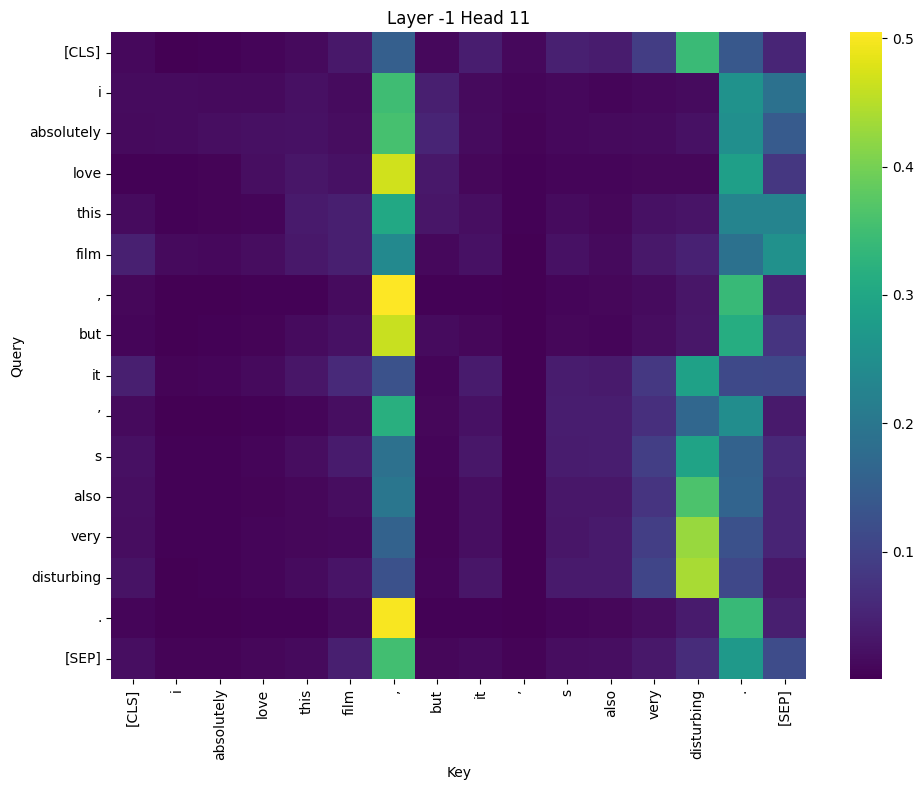

In [19]:
compare_heads(attentions, tokens, layer1=0, layer2=-1)

**Observation**

Analyzing each head in Layer 0 and Layer -1 reveals consistent specialization patterns. In Layer 0, most heads exhibit strong vertical attention toward the [CLS] column, indicating early-stage encoding of sentence-wide information into the classification token. This focus is especially intense in Heads 0, 1, and 10, where [CLS] → [CLS] is bright yellow, often joined by greenish focus on surrounding tokens like “I” and punctuation. Diagonal self-attention (token → token) is another recurring pattern, growing more distinct in heads like 2, 8, and 10, where tokens appear to reinforce their own positions — often visualized as a glowing blue-to-green sword across the matrix. Conversely, Layer -1 heads shift from structural to semantic, showing vertical attention on key tokens like the comma (“,”) and sentiment-heavy words like “disturbing” and “.”. Heads 0–4 repeatedly show strong vertical lines in the comma column, while Heads 5–11 exhibit warmer zones in the bottom-right, aligning with sentiment-bearing tokens and possibly indicating heads tuned to emotional contrast or polarity. Some Layer -1 heads even hint at dual vertical structures (e.g., “disturbing”, “.”) or rectangles of blue and green in the sentence's emotional core. In summary, Layer 0 heads focus on structure ([CLS], identity, diagonal self-reference), while Layer -1 heads extract meaning — attending more to punctuation and sentiment phrases, especially toward the sentence's end.

**Variation 4: Run Across Multiple Sentences**

In [20]:
def analyze_sentences(sentences, layer=-1, head=3):
    for sent in sentences:
        print(f"\nSentence: {sent}")
        attentions, tokens = get_attention(sent)
        attn_matrix = attentions[layer][0][head].numpy()
        plot_attention(attn_matrix, tokens, layer, head)



Sentence: I absolutely love this film, but it’s also very disturbing.


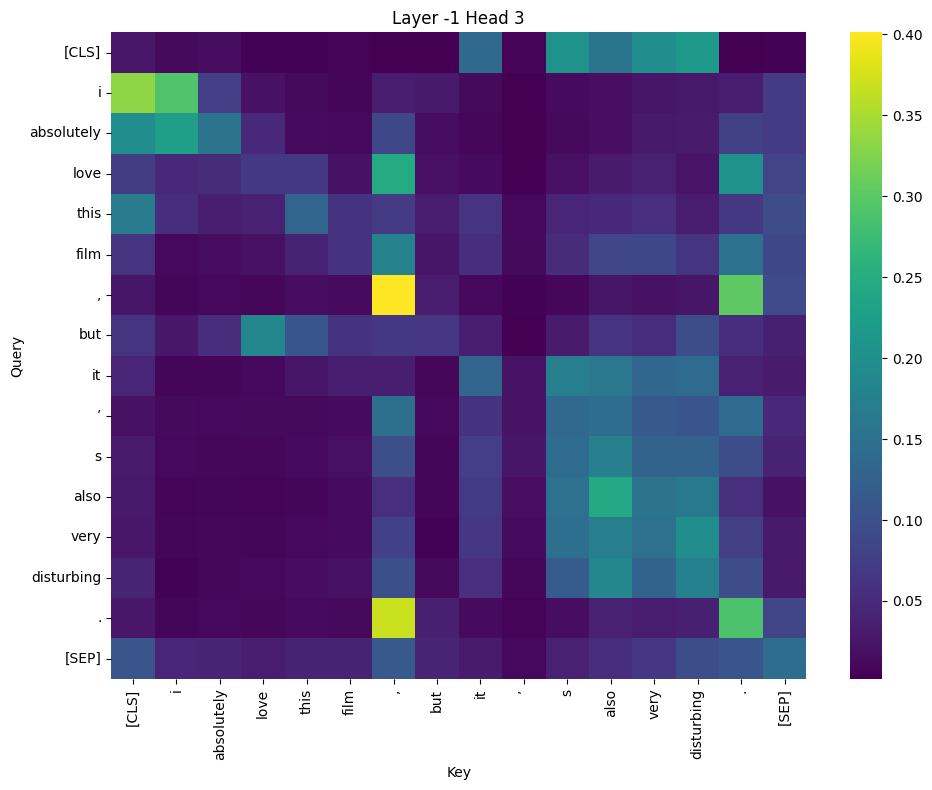


Sentence: The food was terrible, and I wouldn’t recommend it at all.


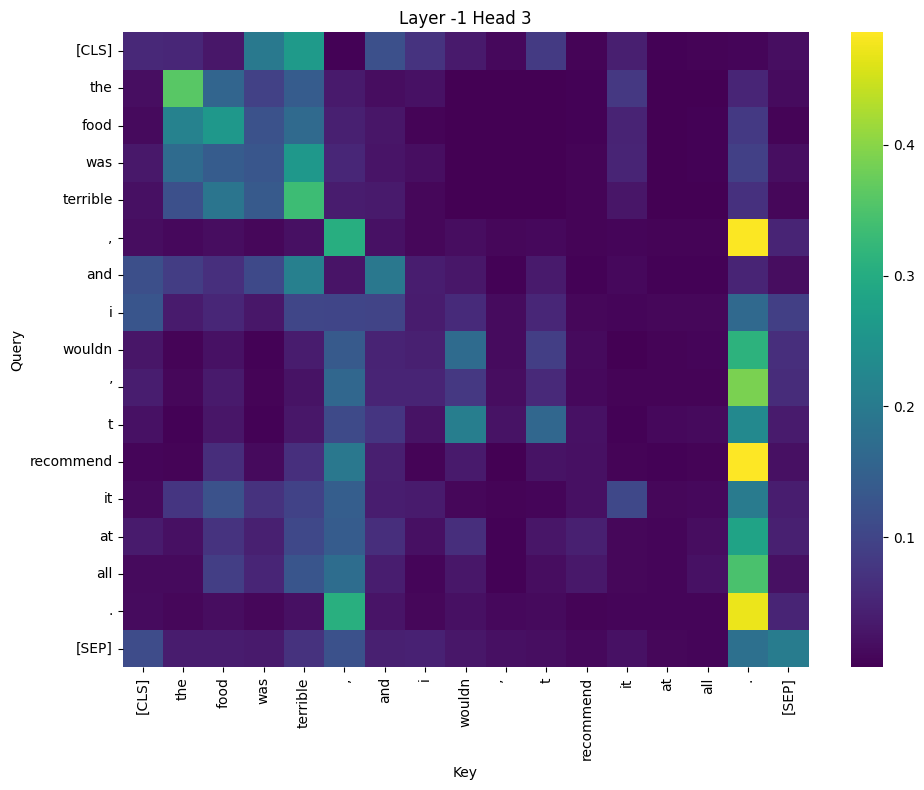


Sentence: I really enjoyed the acting, although the plot was boring.


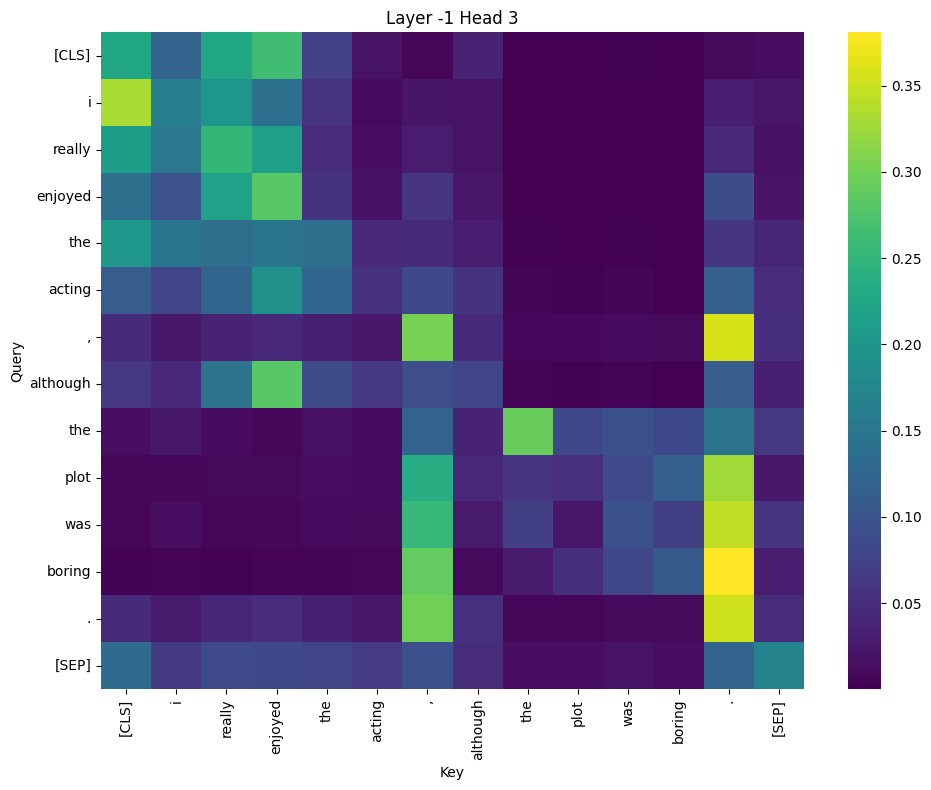


Sentence: The movie was not great, but not terrible either.


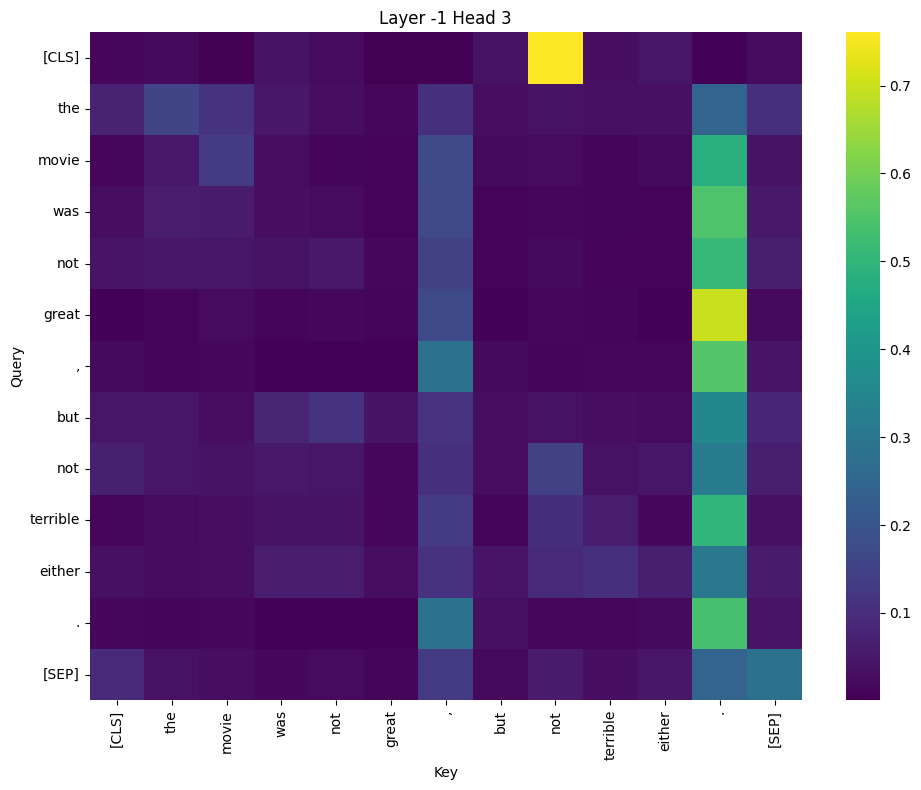


Sentence: It’s brilliantly directed but painfully slow.


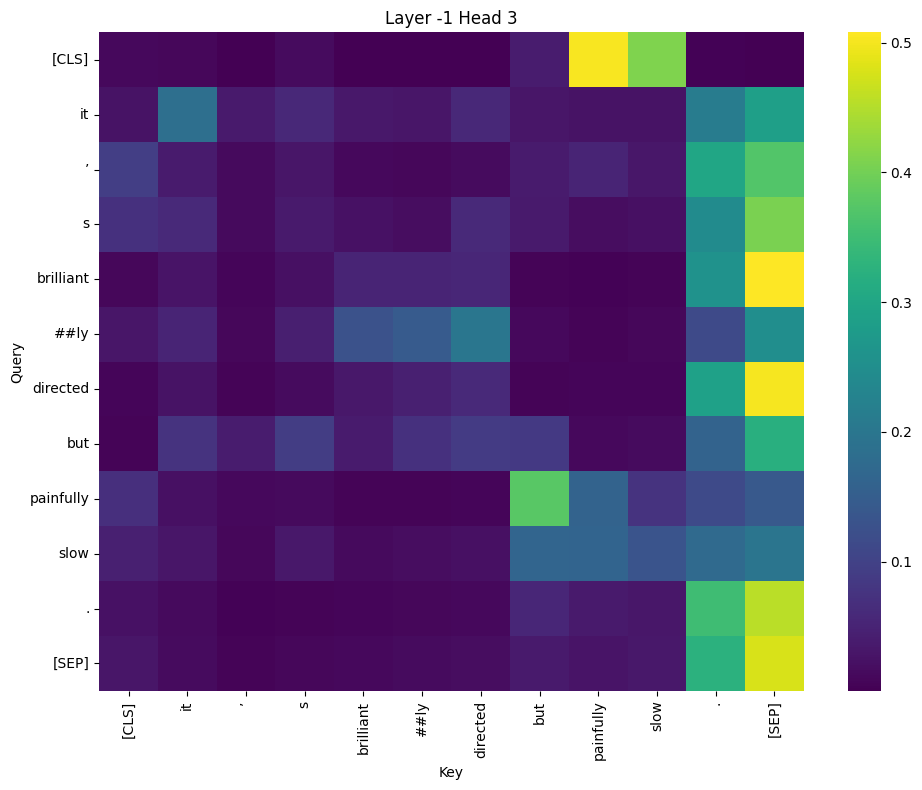

In [21]:
analyze_sentences(sentences, layer=-1, head=3)

**Observation:**

Analyzing different sentences with Layer -1, Head 3 reveals that this head adapts to sentence structure and sentiment positioning, focusing less on single fixed words and more on where the sentiment is located within the sentence. In the sentence “The food was terrible, and I wouldn’t recommend it at all,” attention forms a distinct rectangular zone of greenish-blue values centered around sentiment-heavy words like “terrible” and “recommend,” suggesting that this head scopes sentiment early. A strong vertical line on the “.” column also appears, reflecting punctuation-based anchoring. In contrast, “I really enjoyed the acting, although the plot was boring,” shows focus in the top-left quadrant up to “enjoyed” and adds attention to “.” and “,” later on, tracking the shift in tone. Interestingly, sentences with more evenly distributed or ambiguous sentiment, such as “The movie was not great, but not terrible either” and “It’s brilliantly directed but painfully slow,” show mostly purple matrices — with only mild activity in the last columns (e.g., “.” and [SEP]), suggesting that Head 3 may struggle to localize clear sentiment cues when sentiment is nuanced or contradictory. Overall, this head excels in capturing focused sentiment in clear emotional zones, especially near strong negatives or conclusions, but becomes passive when sentiment is mixed, implicit, or syntactically softened

# 6. Conclusion & Summary of findings

In this task, I analyzed how a DistilBERT sentiment classifier uses self-attention to understand emotion in sentences. I noticed that in early layers like Layer 0, the model focused mostly on structural elements. Many attention heads paid strong attention to the [CLS] token and punctuation, especially commas and periods. I also saw that tokens often attended to themselves, forming diagonal patterns that helped the model understand sentence structure and token positions. These early layers didn’t show much sensitivity to emotion yet, but they built the foundation for deeper interpretation. In contrast, the final layer, Layer -1, focused more on emotionally charged words like “disturbing,” “terrible,” and “recommend.” Attention became more concentrated in the later parts of the sentence, especially when there was a clear emotional tone or a shift introduced by words like “but.”

When I looked at individual heads, I discovered that some were specialized. A few consistently focused on punctuation, while others were clearly tuned to sentiment-heavy areas. One head in particular, Layer -1 Head 3, stood out for its attention to emotional zones within a sentence. It was especially active in negative and clearly emotional sentences, but less so when the sentiment was mixed or vague. I also compared single-head attention to the average across all heads and found that averaging revealed broader patterns, like attention clustering around punctuation and the sentence ending. Overall, my findings show that the model starts by building a structural map of the sentence and then shifts its focus to the emotionally meaningful words. This layered approach helps explain how the model makes its sentiment predictions.